# Introduction

The following work is a project carried out as part of a laboratory during my studies. It is a pre-processing and comparison of two lung tissue segmentation methods on a selected three CT images in DICOM format.

Sources of codes used in the project:


*   https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial
*    https://theaisummer.com/medical-image-python/



## Imports

In [1]:
! pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.6 MB/s eta 0:00:00


In [2]:
! pip install dicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.3/766.3 kB 9.8 MB/s eta 0:00:00


In [18]:
import numpy as np
import pandas as pd
import dicom
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial import ConvexHull
from scipy.ndimage import zoom
from PIL import Image, ImageDraw
from skimage import measure, morphology, filters
from skimage.draw import polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **First method**

In [5]:
input_folder = '/content/drive/MyDrive/Colab Notebooks/lung1'
patients = os.listdir(input_folder)
patients.sort()

## Loading DICOM files

In [6]:
def load_scan(path):
  slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
  try:
    slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
    slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

  for s in slices:
    s.SliceThickness = slice_thickness

  return slices

In [7]:
def get_pixels_hu(slices):
  image = np.stack([s.pixel_array for s in slices])
  image = image.astype(np.int16)
  image[image == -2000] = 0

  for i in range(len(slices)):
      intercept = slices[i].RescaleIntercept
      slope = slices[i].RescaleSlope

      img = image[i].astype(np.float64)

      if slope != 1:
          img *= slope

      img += intercept
      image[i] = img

  return image.astype(np.int16)

### Example of loading file

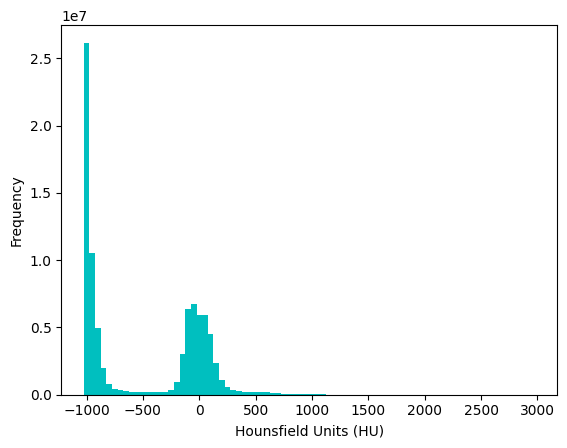

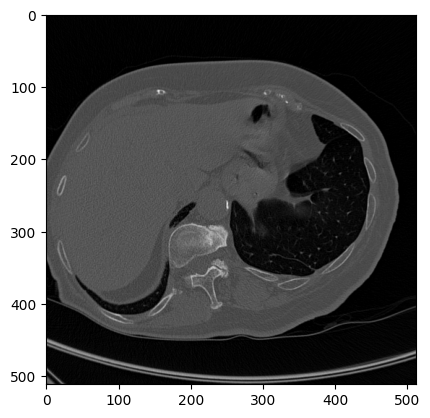

In [8]:
first_patient = load_scan('/content/drive/MyDrive/Colab Notebooks/lung1')
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

## Resampling

In [9]:
def resample(image, scan, new_spacing=[1, 1, 1]):
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

### Example of resampling

In [10]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (332, 512, 512)
Shape after resampling	 (332, 309, 309)


## 3D plotting the scan

In [11]:
def plot_3d(image, threshold=-300):
    p = image.transpose(2, 1, 0)

    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


### Example of ploting 3d scan by HU

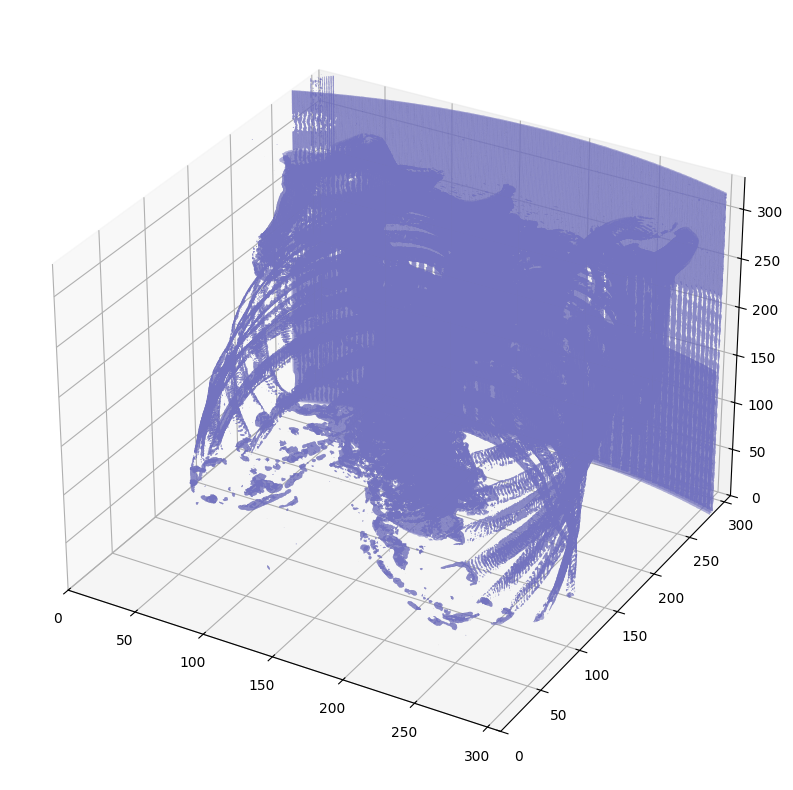

In [12]:
plot_3d(pix_resampled, 400)

## Lung segmentation

In [13]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def segment_lung_mask(image, fill_lung_structures=True):

  binary_image = np.array(image > -600, dtype=np.int8)+1
  labels = measure.label(binary_image)

  background_label = labels[0, 0, 0]

  binary_image[background_label == labels] = 2

  if fill_lung_structures:
    for i, axial_slice in enumerate(binary_image):
      axial_slice = axial_slice - 1
      labeling = measure.label(axial_slice)
      l_max = largest_label_volume(labeling, bg=0)

      if l_max is not None:
        binary_image[i][labeling != l_max] = 1

  binary_image -= 1
  binary_image = 1-binary_image

  labels = measure.label(binary_image, background=0)
  l_max = largest_label_volume(labels, bg=0)
  if l_max is not None:
    binary_image[labels != l_max] = 0

  return binary_image

### Example of lung segmentation

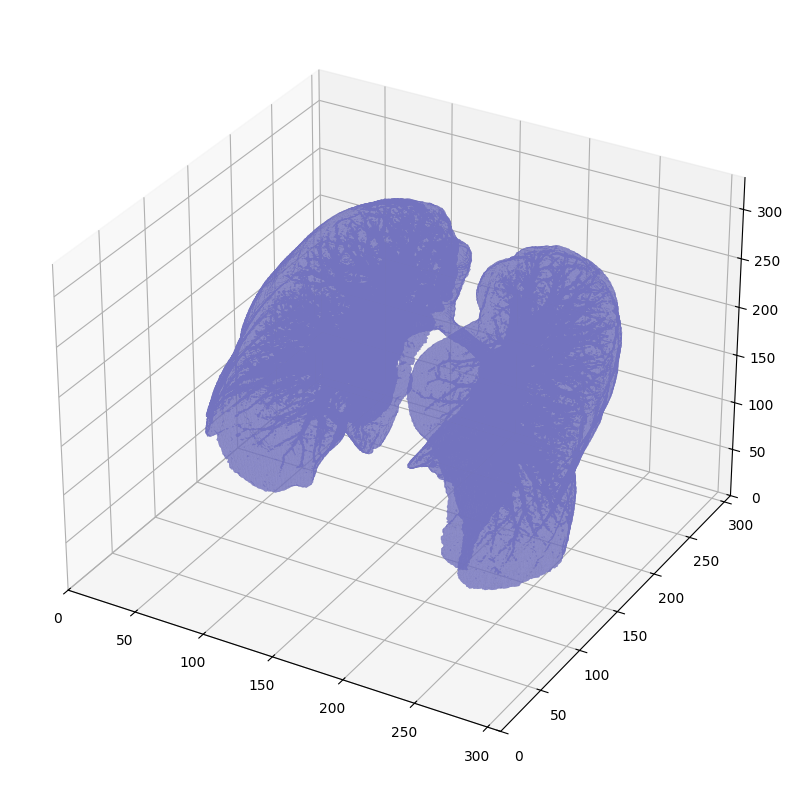

In [14]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
plot_3d(segmented_lungs, 0.5)

Including structures within the lung

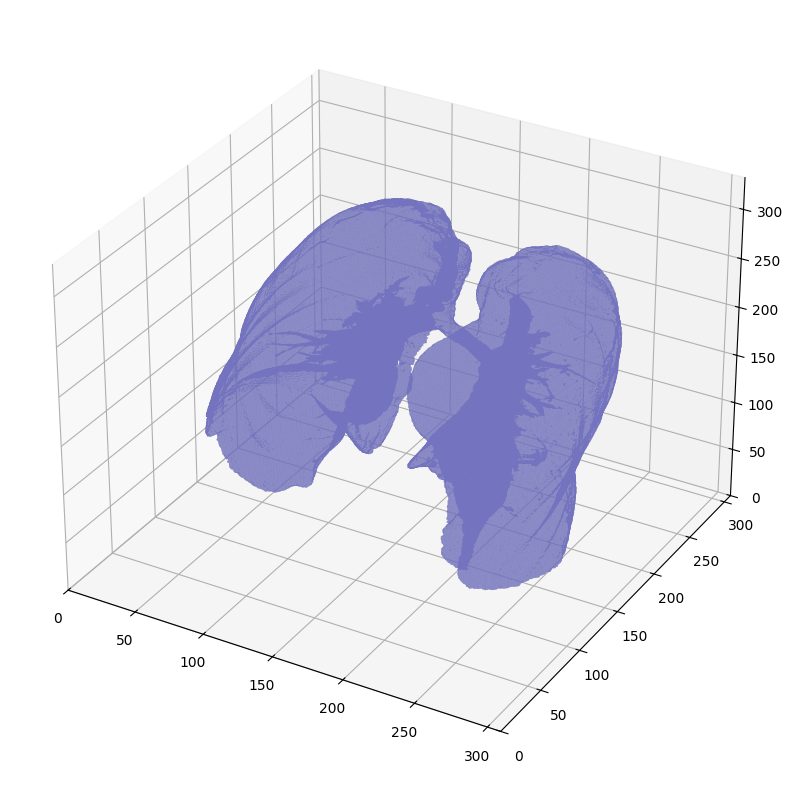

In [15]:
plot_3d(segmented_lungs_fill, threshold=0.5)

## Normalization

In [ ]:
min_bound = -1000.0
max_bound = 400.0

def normalize(image):
  image = (image - min_bound) / (max_bound - min_bound)
  image[image>1] = 1.
  image[image<0] = 0.
  return image

## Zero centering

In [ ]:
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

# Second method

In [19]:
def set_is_closed(contour, tolerance=1.5):
    """Sprawdza, czy kontur jest zamknięty (pierwszy i ostatni punkt są blisko siebie)."""
    if len(contour) < 3:
        return False
    dist = np.linalg.norm(contour[0] - contour[-1])
    return dist < tolerance

def segment_lung_by_contours_dicom(image_2d, hu_min=-1000, hu_max=-300):
    """
    Segmentuje płuca z pojedynczego przekroju CT (2D, w HU) za pomocą konturów.
    Dostosowana do danych DICOM.
    """
    # 1. Przycięcie wartości HU
    clipped = np.clip(image_2d, hu_min, hu_max)
    normed = (clipped - hu_min) / (hu_max - hu_min)

    # 2. Znajdowanie konturów
    contours = measure.find_contours(normed, 0.95)

    # 3. Filtrowanie konturów – wybór płuc (na podstawie objętości i zamknięcia)
    lung_contours = []
    vol_contours = []
    for contour in contours:
        try:
            hull = ConvexHull(contour)
            if hull.volume > 2000 and set_is_closed(contour):
                lung_contours.append(contour)
                vol_contours.append(hull.volume)
        except:
            continue  # nie udało się utworzyć otoczki

    # 4. Odrzucenie największego konturu (ciało), zostają płuca
    if len(lung_contours) > 2:
        vol_contours, lung_contours = (list(t) for t in zip(*sorted(zip(vol_contours, lung_contours))))
        lung_contours.pop(-1)

    # 5. Tworzenie maski z konturów
    lung_mask = np.array(Image.new('L', image_2d.shape, 0))
    for contour in lung_contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image_2d.shape, 0)
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        lung_mask += mask

    lung_mask[lung_mask > 1] = 1
    return lung_mask.T.astype(np.uint8)  # transpose, żeby zgadzało się z orientacją DICOM


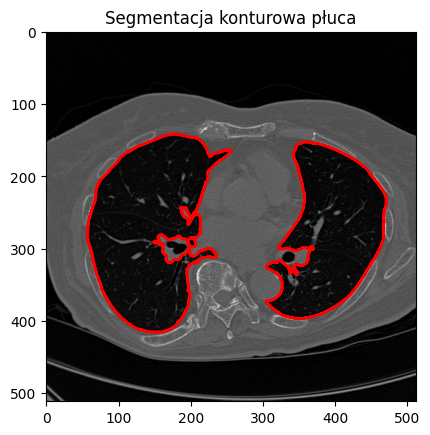

In [20]:
slices = load_scan("/content/drive/MyDrive/Colab Notebooks/lung1")
image = get_pixels_hu(slices)
slice_idx = len(image) // 2

lung_mask = segment_lung_by_contours_dicom(image[slice_idx])

plt.imshow(image[slice_idx], cmap="gray")
plt.contour(lung_mask, colors="r")
plt.title("Segmentacja konturowa płuca")
plt.show()


In [22]:
def plot_3d_from_mask(mask_3d):

    p = mask_3d.transpose(2, 1, 0)  # dopasowanie osi do marching_cubes
    verts, faces, _, _ = measure.marching_cubes(p, level=0.5)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    mesh.set_facecolor([0.6, 0.3, 0.6])  # lekko fioletowy
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.title("3D Rekonstrukcja płuc (kontury)")
    plt.show()

In [23]:
def segment_lung_by_contours_3d(image_3d):
    depth, height, width = image_3d.shape
    lung_mask_3d = np.zeros_like(image_3d, dtype=np.uint8)

    for i in range(depth):
        slice_2d = image_3d[i]
        mask_2d = segment_lung_by_contours_dicom(slice_2d)
        lung_mask_3d[i] = mask_2d

    return lung_mask_3d

# Compering methods by Dice-Sørensen coefficient

In [24]:
def dice_coefficient(mask1, mask2):

    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    return 2. * intersection / (mask1.sum() + mask2.sum() + 1e-8)


In [25]:
def resample_to_shape(mask, new_shape):
    factors = [n / o for n, o in zip(new_shape, mask.shape)]
    return zoom(mask, factors, order=0)

In [26]:
# Pierwsza segmentacja
patient = load_scan('/content/drive/MyDrive/Colab Notebooks/lung1')
patient_pixels = get_pixels_hu(patient)
pix_i_resampled, spacing_i = resample(patient_pixels, patient, [1,1,1])

mask_a = segment_lung_mask(pix_i_resampled, False)

# Druga segmentacja
slices_i = load_scan("/content/drive/MyDrive/Colab Notebooks/lung1")
image_i = get_pixels_hu(slices_i)

mask_b = segment_lung_by_contours_3d(image_i)

print("Unikalne wartości w mask_a:", np.unique(mask_a))
print("Unikalne wartości w mask_b:", np.unique(mask_b))

# Wymagana zmiana krztałtu
mask_a_resampled = resample_to_shape(mask_a, mask_b.shape)

print("Unikalne wartości w mask_a:", np.unique(mask_a))
print("Unikalne wartości w mask_b:", np.unique(mask_b))

# Obliczanie współczynnika Dice
dice_total = dice_coefficient(mask_a_resampled, mask_b)
print(f"Współczynnik Dice dla całych płuc (3D): {dice_total:.4f}")

Unikalne wartości w mask_a: [0 1]
Unikalne wartości w mask_b: [0 1]
Unikalne wartości w mask_a: [0 1]
Unikalne wartości w mask_b: [0 1]
Współczynnik Dice dla całych płuc (3D): 0.9211
